In [19]:
from os import listdir
from os.path import isfile, join
import re
demographic_files = [f for f in listdir('BabyNames/') if isfile(join('BabyNames/', f)) and re.search('^yob\d', f)]
demographic_files.sort()

In [21]:
import pandas as pd
def read_file(file_name):
    year = re.search('yob(\d+).txt', file_name).group(1)
    df = pd.read_csv('BabyNames/{0}'.format(file_name), sep=',', header=None)
    df.columns = ['Name', 'Sex', 'Count']
    df['Year'] = year
    return df

read_data_frames = [read_file(f_name) for f_name in demographic_files]

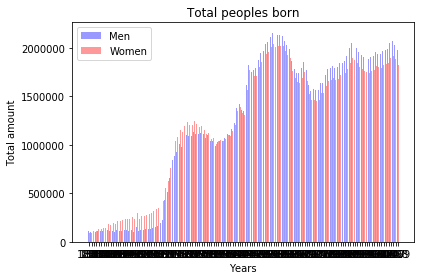

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

start_index = 0
end_index = -1

n_groups = len(read_data_frames[start_index:end_index])

years = []
mens_amount = []
womens_amount = []

for frame in read_data_frames[start_index:end_index]:
    years += [frame.loc[0]['Year']]
    womens_amount += [frame.loc[frame['Sex'] == 'F', ['Count']].sum()['Count']]
    mens_amount += [frame.loc[frame['Sex'] == 'M', ['Count']].sum()['Count']]

years_values = tuple(years)
womens_values = tuple(womens_amount)
mens_values = tuple(mens_amount)

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.4

opacity = 0.4

rects1 = ax.bar(index, mens_values, bar_width,
                alpha=opacity, color='b',
                label='Men')

rects2 = ax.bar(index + bar_width, womens_values, bar_width,
                alpha=opacity, color='r',
                label='Women')

ax.set_xlabel('Years')
ax.set_ylabel('Total amount')
ax.set_title('Total peoples born')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(years_values)
ax.legend()

fig.tight_layout()
plt.rcParams["figure.figsize"] = [30, 4.8]
plt.show()

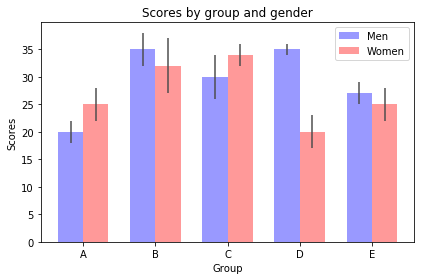

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

n_groups = 5

means_men = (20, 35, 30, 35, 27)
std_men = (2, 3, 4, 1, 2)

means_women = (25, 32, 34, 20, 25)
std_women = (3, 5, 2, 3, 3)

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, means_men, bar_width,
                alpha=opacity, color='b',
                yerr=std_men, error_kw=error_config,
                label='Men')

rects2 = ax.bar(index + bar_width, means_women, bar_width,
                alpha=opacity, color='r',
                yerr=std_women, error_kw=error_config,
                label='Women')

ax.set_xlabel('Group')
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('A', 'B', 'C', 'D', 'E'))
ax.legend()

fig.tight_layout()
plt.show()